%%html
<style>
    .exercise {
        background-color: #AFEEEE;
        font-style: normal;
        text-align: justify;
        margin-left: 0px;
        margin-right: 10px;
        margin-top: 10px;
        margin-bottom: 0px;
        display: block;
    }
</style>


<center style="font-size:25px;padding-bottom:10px;">Midterm - Procesos Estocásticos</center>
<center style="font-size:20px;padding-bottom:10px;">Máster en Ciencia de Datos -  Universidad Autónoma de Madrid</center>
<center style="font-size:20px;padding-bottom:10px;">José Antonio Álvarez Ocete</center>

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
import random
from collections import Counter, defaultdict

<div class="exercise">
<h1>Enunciado</h1>

Consideremos la siguente cadena de Markov:

TODO: FIGURE

(se asuma que en cada estado hay una flecha hasta el mismo estado que hace que la suma de las
probabilidades en salida sea 1), con $p = 0.3$.

$i)$ Determinar la matriz de transición de la cadena.
</div>

Obtenemos la matriz de transición consultando el grafo anterior y colocando en la posición $i,j$ la probabilidad de transición del estado $i$ al $j$. En la diagonal colocamos la probabilidad de mantenernos en el estado $i,i$, siendo esta $1$ menos las la suma de las probabilidades de salir de dicho estado.

$$
    P = 
    \begin{pmatrix}
        1-p & p & 0 & 0 & 0 & 0 \\
        0 & 1-p & p/2 & 0 & p/2 & 0 & \\
        1/4 & 0 & 1/4 & 1/4 & 1/4 & 0 \\
        q & 0 & 0 & 0.9-q & 0.1 & 0 \\
        0 & 0 & 0 & 0 & 1/2 & 1/2 \\
        0 & 0 & 0 & 1/4 & 1/2 & 1/4
    \end{pmatrix}
$$

Como medida de comprobación podemos asegurarnos de que todas las filas sumen $1$, como hacen.

<div class="exercise">

$ii)$ Simular el funcionamiento de la cadena y hacer una estimación de conjunto de $h_0^2$ y $h_0^5$ para $q = 0.1$ y $q = 0$.
</div>

TODO: explicación

In [3]:
def get_P(p, q):
    return np.array([[  1-p,    p,    0.0,    0.0,    0.0,    0.0],
                    [  0.0,  1-p,  p/2.0,    0.0,   p/2.0,   0.0],
                    [1/4.0,  0.0,  1/4.0,   1/4.0,  1/4.0,   0.0],
                    [    q,  0.0,    0.0, 1-q-0.1,    0.1,   0.0],
                    [  0.0,  0.0,    0.0,     0.0,  1/2.0, 1/2.0],
                    [  0.0,  0.0,    0.0,    1/4.0, 1/2.0, 1/4.0]
                    ])

def collapse(state):
    """
        Given a state, collapses it to a single position
        with the given probabilities in the state. For example, given:
            state = [1/3, 2/3]
        collapse(state) will output:
        - [1, 0] with probability 1/3
        - [0, 1] with probability 2/3
    """
    F_n = np.cumsum(state)
    F_n = np.insert(F_n, 0, 0, axis=0)
    r = random.uniform(0, 1)
    collapsed = np.zeros(len(state))
    for i, (x1, x2) in enumerate(zip(F_n[:-1], F_n[1:])):
        if r > x1 and r < x2:
            collapsed[i] = 1
    return collapsed

def simulate_H(from_m, to_m, P, steps=10**3):
    """
        Simulate a single random walk through the markov chain
        described by P and compute the first hitting time from_m to_m.

        Returns either a natural number if to_m was reached in that time,
        or -1 if to_m was never reached.
    """
    if from_m == to_m:
        return 0

    state = np.zeros(len(P[0]))
    state[from_m] = 1

    for step in range(1, steps+1):
        state = collapse(state @ P)
        if state[to_m] == 1:
            return step
    return -1

def simulate_h(from_m, to_m, P, steps=10**3, n_random_walks=10**3):
    """
        Simulate `n_random_walks` random walks through the markov chain
        described by P and estimate the hitting from_m to_m.

        Returns the estimation of the probability of hitting from_m
        to_m in `steps` steps.
    """
    total_hits = 0
    for _ in range(n_random_walks):
        total_hits += 1 + min(0, simulate_H(from_m=from_m, to_m=to_m, P=P, steps=steps))
    return total_hits / n_random_walks

def simulate_h_specific(from_m, to_m, p=0.3, q=0.1, steps=10**3, n_random_walks=10**3):
    P = get_P(p, q)
    prob = simulate_h(from_m=from_m, to_m=to_m, P=P, steps=steps, n_random_walks=n_random_walks)
    print('(q={}) - Simulated h{}{} = {}'.format(q, from_m, to_m, prob))

In [4]:
random.seed(123)
simulate_h_specific(from_m=0, to_m=2, q=0.1)
simulate_h_specific(from_m=0, to_m=5, q=0.1)
simulate_h_specific(from_m=0, to_m=2, q=0)
simulate_h_specific(from_m=0, to_m=5, q=0)

(q=0.1) - Simulated h02 = 1.0
(q=0.1) - Simulated h05 = 1.0
(q=0) - Simulated h02 = 0.497
(q=0) - Simulated h05 = 1.0


<div class="exercise">

$iii)$ Simular el funcionamiento de la cadena y hacer una estimación de conjunto de $k_0^2$ y $k_4^2$ para $q = 0.1$ y $q = 0$.
</div>

In [5]:
def simulate_k(from_m, to_m, P, steps=10**3, n_random_walks=10**3):
    """
        Simulate `n_random_walks` random walks through the markov chain
        described by P and estimate the mean hitting from_m to_m.

        Returns the estimation of the mean hittim time from_m to_m in `steps` steps.
        If any of the random walks didn't reach to_m, -1 is returned, meaning
        the expected time is infinite.
    """
    Hs = [ simulate_H(from_m=from_m, to_m=to_m, P=P, steps=steps) for _ in range(n_random_walks) ]
    return -1 if -1 in Hs else np.mean(Hs)

def simulate_k_specific(from_m, to_m, p=0.3, q=0.1, steps=10**3, n_random_walks=10**3):
    P = get_P(p, q)
    prob = simulate_k(from_m=from_m, to_m=to_m, P=P, steps=steps, n_random_walks=n_random_walks)
    print('(q={}) - Simulated k{}{} = {}'.format(q, from_m, to_m, prob))

In [6]:
simulate_k_specific(from_m=0, to_m=2, q=0.1)
simulate_k_specific(from_m=4, to_m=2, q=0.1)
simulate_k_specific(from_m=0, to_m=2, q=0)
simulate_k_specific(from_m=4, to_m=2, q=0)

(q=0.1) - Simulated k02 = 45.454
(q=0.1) - Simulated k42 = 72.049
(q=0) - Simulated k02 = -1
(q=0) - Simulated k42 = -1


<div class="exercise">

$iv)$ Usar el sistema de ecuaciones lineares oportuno para determinar los valores teóricos correspondientes a las cantidades estimadas y comparar con los valores determinados por medio de la simulación.

Nota: si una cantidad $k$ es $\infty$ la simulación claramente no puede dar su valor real. Discutir este caso.
</div>

In [7]:
def theoretical_h(P, to_m):
    n = len(P[0])
    A = P - np.identity(n)
    b = np.zeros(n)
    b[to_m] = 1
    A[to_m] = b
    return optimize.nnls(A, b)[0]

def theorical_h_specific(from_m, to_m, p=0.3, q=0.1):
    P = get_P(p, q)
    result = theoretical_h(P, to_m)
    print('(q={}) - Theoretical h{}{} = {}'.format(q, from_m, to_m, result[from_m]))

In [8]:
theorical_h_specific(from_m=0, to_m=2, q=0.1)
theorical_h_specific(from_m=0, to_m=5, q=0.1)
theorical_h_specific(from_m=0, to_m=2, q=0)
theorical_h_specific(from_m=0, to_m=5, q=0)

(q=0.1) - Theoretical h02 = 1.0000000000000007
(q=0.1) - Theoretical h05 = 0.9999999999999981
(q=0) - Theoretical h02 = 0.5
(q=0) - Theoretical h05 = 0.9999999999999986


In [12]:
def theoretical_k(P, to_m):
    n = len(P[0])
    A = np.identity(n) - P
    b = np.ones(n)
    b[to_m] = 0
    A[to_m] = np.logical_not(b)
    return optimize.nnls(A, b)[0]

def theorical_k_specific(from_m, to_m, p=0.3, q=0.1):
    P = get_P(p, q)
    h = theoretical_h(P, to_m)[from_m]

    result = 'infinity'
    if h > 0.995:
        result = theoretical_k(P, to_m)[from_m]

    print('(q={}) - Theoretical k{}{} = {}'.format(q, from_m, to_m, result))

In [13]:
theorical_k_specific(from_m=0, to_m=2, q=0.1)
theorical_k_specific(from_m=4, to_m=2, q=0.1)
theorical_k_specific(from_m=0, to_m=2, q=0)
theorical_k_specific(from_m=4, to_m=2, q=0)

(q=0.1) - Theoretical k02 = 43.33333333333339
(q=0.1) - Theoretical k42 = 73.33333333333343
(q=0) - Theoretical k02 = infinity
(q=0) - Theoretical k42 = infinity


<div class="exercise">

$v)$ Para el caso $q = 0.1$, dibujar el grafico de $g(t) = P[H_0^{\{4\}} = t]$
</div>


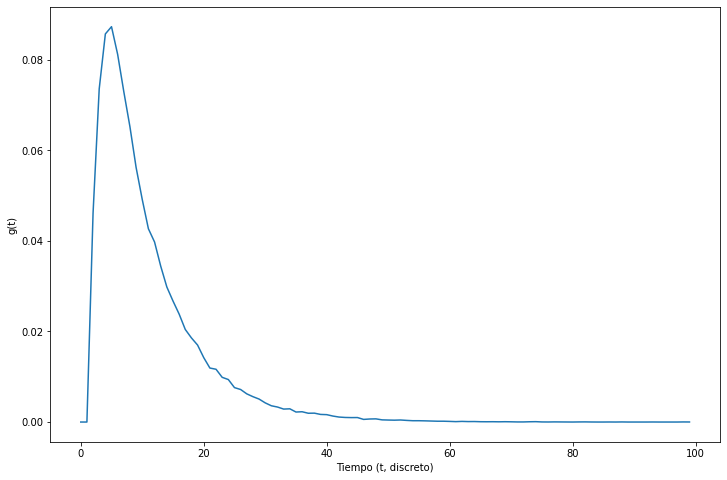

In [29]:
def plot_g(p=0.3, q=0.1, from_m=0, to_m=4, max_steps=100, n_simulations=10**5):
    P = get_P(p, q)

    Hs = [ simulate_H(from_m=from_m, to_m=to_m, P=P, steps=max_steps) for _ in range(n_simulations) ]
    counted = defaultdict(int, dict(Counter(Hs)))
    y = np.array([ counted[i] for i in range(max_steps) ]) / n_simulations
    
    plt.figure(figsize=(12, 8))
    plt.plot(list(range(max_steps)), y)
    plt.xlabel('Tiempo (t, discreto)')
    plt.ylabel('g(t)')
    plt.show()

plot_g()

<div class="exercise">

$vi)$ Razonar si $H_0^{\{4\}} , H_0^{\{5\}}$.
</div>